In [16]:
!pip install torch torchvision transformers

import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig
import random
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/DR_dataset'

/content/drive/MyDrive/DR_dataset


In [10]:
def create_label_map(csv_path):
  df = pd.read_csv(csv_path)
  label_map = dict(zip(df['diagnosis'].unique(), df['diagnosis'].unique()))
  return label_map

csv_path = "train.csv"
label_map = create_label_map(csv_path)

In [11]:
def create_train_val_split(csv_path, train_ratio=0.8):
  df = pd.read_csv(csv_path)
  train_df, val_df = train_test_split(df, test_size=1-train_ratio, random_state=42, stratify=df['diagnosis'])
  return train_df, val_df

train_df, val_df = create_train_val_split(csv_path)

In [5]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.label_dict = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate_DR': 4}
        
        # Iterate through the folders and collect image paths and labels
        self.image_paths = []
        self.labels = []
        for label_folder, label_id in self.label_dict.items():
            folder_path = os.path.join(self.root_dir, label_folder)
            for image_name in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, image_name))
                self.labels.append(label_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        return image, label


In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
root_dir = 'gaussian_filtered_images/gaussian_filtered_images'
dataset = DiabeticRetinopathyDataset(root_dir, transforms=data_transforms)

# Calculate the number of samples for training and validation sets
num_samples = len(dataset)
num_train = int(0.8 * num_samples)
num_val = num_samples - num_train

# Generate random indices for the training and validation sets
indices = list(range(num_samples))
random.shuffle(indices)
train_indices, val_indices = indices[:num_train], indices[num_train:]

# Create the training and validation datasets using the random indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)



In [8]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
from transformers import ViTConfig

# Load the pre-trained ViT model
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Load the model with the custom configuration
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", config=config)

# Update the classifier layer to match the number of classes in your dataset
num_labels = 5
model.classifier = torch.nn.Linear(config.hidden_size, num_labels)


/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
# Define the proportion of the dataset to use (e.g., 0.1 for 10%)
subset_proportion = 0.1

# Calculate the number of samples for the smaller dataset, training, and validation sets
num_samples_subset = int(subset_proportion * num_samples)
num_train_subset = int(0.8 * num_samples_subset)
num_val_subset = num_samples_subset - num_train_subset

# Generate random indices for the smaller dataset, training, and validation sets
subset_indices = random.sample(indices, num_samples_subset)
train_indices_subset, val_indices_subset = subset_indices[:num_train_subset], subset_indices[num_train_subset:]

# Create the smaller training and validation datasets using the random indices
train_dataset_subset = torch.utils.data.Subset(dataset, train_indices_subset)
val_dataset_subset = torch.utils.data.Subset(dataset, val_indices_subset)

train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader_subset = DataLoader(val_dataset_subset, batch_size=batch_size, shuffle=False, num_workers=4)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_dataloader_subset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        
    train_loss = train_loss / len(train_dataset_subset)
    train_acc = train_corrects.double() / len(train_dataset_subset)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

print("Training completed.")


Epoch 1/10 - Train Loss: 0.9807, Train Acc: 0.6404
Epoch 2/10 - Train Loss: 0.6116, Train Acc: 0.7637
Epoch 3/10 - Train Loss: 0.4303, Train Acc: 0.8390
Epoch 4/10 - Train Loss: 0.3266, Train Acc: 0.8699
Epoch 5/10 - Train Loss: 0.1836, Train Acc: 0.9384
Epoch 6/10 - Train Loss: 0.0593, Train Acc: 0.9932
Epoch 7/10 - Train Loss: 0.0288, Train Acc: 0.9966
Epoch 8/10 - Train Loss: 0.0115, Train Acc: 1.0000
Epoch 9/10 - Train Loss: 0.0054, Train Acc: 1.0000
Epoch 10/10 - Train Loss: 0.0042, Train Acc: 1.0000
Training completed.


In [14]:
model.eval()

val_loss = 0.0
val_corrects = 0
val_preds = []
val_true = []

with torch.no_grad():
    for inputs, labels in val_dataloader_subset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, labels)
        
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

val_loss = val_loss / len(val_dataset_subset)
val_acc = val_corrects.double() / len(val_dataset_subset)

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")


Validation Loss: 1.1008, Validation Acc: 0.7838


In [25]:
successful_example = None
unsuccessful_example = None

for i, (pred, true_label) in enumerate(zip(val_preds, val_true)):
    if pred == true_label and successful_example is None:
        successful_example = i
    if pred != true_label and unsuccessful_example is None:
        unsuccessful_example = i
    if successful_example is not None and unsuccessful_example is not None:
        break

successful_image, successful_label = val_dataset_subset[successful_example]
unsuccessful_image, unsuccessful_label = val_dataset_subset[unsuccessful_example]

# Convert tensors to PIL images for visualization
successful_image_pil = transforms.ToPILImage()(successful_image)
unsuccessful_image_pil = transforms.ToPILImage()(unsuccessful_image)


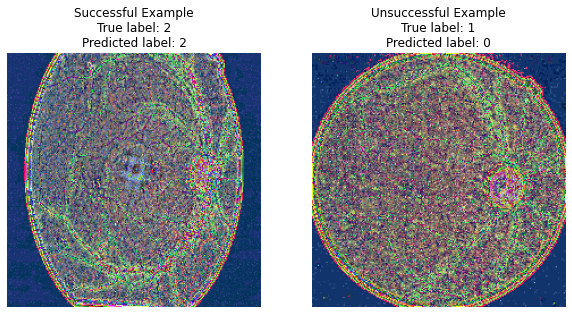

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the successful example
axs[0].imshow(successful_image_pil)
axs[0].set_title(f"Successful Example\nTrue label: {successful_label}\nPredicted label: {val_preds[successful_example]}")
axs[0].axis('off')

# Display the unsuccessful example
axs[1].imshow(unsuccessful_image_pil)
axs[1].set_title(f"Unsuccessful Example\nTrue label: {unsuccessful_label}\nPredicted label: {val_preds[unsuccessful_example]}")
axs[1].axis('off')

plt.show()


To avoid overfitting to training data, we perform data augmentation, early stopping, and regularization.

In [27]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
root_dir = 'gaussian_filtered_images/gaussian_filtered_images'
dataset = DiabeticRetinopathyDataset(root_dir, transforms=data_transforms)

# Calculate the number of samples for training and validation sets
num_samples = len(dataset)
num_train = int(0.8 * num_samples)
num_val = num_samples - num_train

# Generate random indices for the training and validation sets
indices = list(range(num_samples))
random.shuffle(indices)
train_indices, val_indices = indices[:num_train], indices[num_train:]

# Create the training and validation datasets using the random indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [30]:
from transformers import ViTConfig

# Load the pre-trained ViT model
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Load the model with the custom configuration
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", config=config)

# Update the classifier layer to match the number of classes in your dataset
num_labels = 5
model.classifier = torch.nn.Linear(config.hidden_size, num_labels)


In [31]:
# Define the proportion of the dataset to use (e.g., 0.1 for 10%)
subset_proportion = 0.1

# Calculate the number of samples for the smaller dataset, training, and validation sets
num_samples_subset = int(subset_proportion * num_samples)
num_train_subset = int(0.8 * num_samples_subset)
num_val_subset = num_samples_subset - num_train_subset

# Generate random indices for the smaller dataset, training, and validation sets
subset_indices = random.sample(indices, num_samples_subset)
train_indices_subset, val_indices_subset = subset_indices[:num_train_subset], subset_indices[num_train_subset:]

# Create the smaller training and validation datasets using the random indices
train_dataset_subset = torch.utils.data.Subset(dataset, train_indices_subset)
val_dataset_subset = torch.utils.data.Subset(dataset, val_indices_subset)

train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader_subset = DataLoader(val_dataset_subset, batch_size=batch_size, shuffle=False, num_workers=4)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_dataloader_subset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        
    train_loss = train_loss / len(train_dataset_subset)
    train_acc = train_corrects.double() / len(train_dataset_subset)

    if train_acc > 0.99:
        break
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

print("Training completed.")


Epoch 1/10 - Train Loss: 1.0738, Train Acc: 0.6301
Epoch 2/10 - Train Loss: 0.6841, Train Acc: 0.7260
Epoch 3/10 - Train Loss: 0.4926, Train Acc: 0.8288
Epoch 4/10 - Train Loss: 0.2935, Train Acc: 0.8973
Epoch 5/10 - Train Loss: 0.1599, Train Acc: 0.9623
Epoch 6/10 - Train Loss: 0.1815, Train Acc: 0.9315
Training completed.


In [33]:
train_loss, train_acc

(0.04409671799369054, tensor(0.9932, dtype=torch.float64))

In [34]:
model.eval()

val_loss = 0.0
val_corrects = 0
val_preds = []
val_true = []

with torch.no_grad():
    for inputs, labels in val_dataloader_subset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, labels)
        
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

val_loss = val_loss / len(val_dataset_subset)
val_acc = val_corrects.double() / len(val_dataset_subset)

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")


Validation Loss: 0.8559, Validation Acc: 0.7162


In [35]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
root_dir = 'gaussian_filtered_images/gaussian_filtered_images'
dataset = DiabeticRetinopathyDataset(root_dir, transforms=data_transforms)

# Calculate the number of samples for training and validation sets
num_samples = len(dataset)
num_train = int(0.8 * num_samples)
num_val = num_samples - num_train

# Generate random indices for the training and validation sets
indices = list(range(num_samples))
random.shuffle(indices)
train_indices, val_indices = indices[:num_train], indices[num_train:]

# Create the training and validation datasets using the random indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [37]:
model.eval()

val_loss = 0.0
val_corrects = 0
val_preds = []
val_true = []

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, labels)
        
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

val_loss = val_loss / len(val_dataset)
val_acc = val_corrects.double() / len(val_dataset)

print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")


Validation Loss: 0.9347, Validation Acc: 0.7340
